In [91]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF 
import numpy as np
from sklearn.metrics import mean_absolute_error
import math
import os


In [188]:
def calculate_distance_to_line(xp, yp, yaw, x1=0.749876, y1=-2.240269, x2=0.811162, y2=-0.986052):
    yaw_radians = math.radians(yaw)
    # 计算直线的斜率 k 和截距 b
    k = (y2 - y1) / (x2 - x1)
    b = y1 - k * x1
    # 计算射线的斜率 m 和截距 c
    m = math.tan(yaw_radians)
    c = yp - m * xp
    # 计算交点
    if k != m:  # 确保斜率不相同，防止平行线
        x_intersect = (c - b) / (k - m)
        y_intersect = k * x_intersect + b
        # 计算距离
        distance = math.sqrt((x_intersect - xp)**2 + (y_intersect - yp)**2)
    else:
        distance = float('inf')  # 平行线没有交点
    return distance




def process_data(file_paths):
    # Initialize empty lists to store data
    whisker1_data = []
    whisker2_data = []
    laser1_data = []
    laser2_data = []
    GT1_data = []
    GT2_data = []
    orientation_data = []
    position_data = []

    for file_path in file_paths:
        # Read data from file
        data = pd.read_csv(file_path)
        
        # Extract data columns
        whisker1_data.append(data.iloc[:, 13:16].values)
        whisker2_data.append(data.iloc[:, 16:19].values)
        laser1 = data.iloc[:, -5].values+20*np.tan(np.radians(np.rad2deg(data.iloc[:, -1])-2.8))
        laser2 = data.iloc[:, -5].values-20*np.tan(np.radians(np.rad2deg(data.iloc[:, -1])-2.8))
        laser1_data.append( np.where(laser1 > 217, 0, 217 - laser1))
        laser2_data.append( np.where(laser2 > 217, 0, 217 - laser2))
        GT = data.apply(lambda row: calculate_distance_to_line(row.iloc[-2], row.iloc[-4], np.rad2deg(row.iloc[-1])-2.8), axis=1) * 1000
        GT1 = GT+20*np.tan(np.radians(np.rad2deg(data.iloc[:, -1])-2.8))
        GT2 = GT-20*np.tan(np.radians(np.rad2deg(data.iloc[:, -1])-2.8))
        GT1_data.append( np.where(GT1 > 240, 0, 240 - GT1))
        GT2_data.append( np.where(GT2 > 240, 0, 240 - GT2))
        orientation_data.append(data.iloc[:, -6].values)
        position_data.append(data.iloc[:, 1:3].values)
    
    # Concatenate data from all files
    whisker1_data = np.concatenate(whisker1_data)
    whisker2_data = np.concatenate(whisker2_data)
    laser1_data = np.concatenate(laser1_data)
    laser2_data = np.concatenate(laser2_data)
    GT1_data = np.concatenate(GT1_data)
    GT2_data = np.concatenate(GT2_data)
    orientation_data = np.concatenate(orientation_data)
    position_data = np.concatenate(position_data)
    
    return whisker1_data, whisker2_data, laser1_data, laser2_data, GT1_data, GT2_data, orientation_data, position_data

def filter_data_both(whisker_data1, whisker_data2, laser1_data,laser2_data, GT_data1, GT_data2, threshold, orientation_data, position_data):
    filter_indices = (whisker_data1[:,0] >= threshold) & (whisker_data2[:,0] >= threshold) & (GT_data1 > 0) & (GT_data2 > 0)
    whisker1_filtered = whisker_data1[filter_indices]
    whisker2_filtered = whisker_data2[filter_indices]
    laser1_filtered = laser1_data[filter_indices]
    laser2_filtered = laser2_data[filter_indices]
    GT1_filtered = GT_data1[filter_indices]
    GT2_filtered = GT_data2[filter_indices]
    orientation_filtered = orientation_data[filter_indices]
    position_filtered = position_data[filter_indices]
    return whisker1_filtered, whisker2_filtered, laser1_filtered,laser2_filtered, GT1_filtered, GT2_filtered, orientation_filtered, position_filtered

In [213]:
from sklearn.preprocessing import StandardScaler

file_paths = ['20241209-2/data1.csv', '20241209-2/data17.csv', '20241209-2/data2.csv', '20241209-2/data16.csv', 
              '20241209-2/data10.csv', '20241209-2/data15.csv', '20241209-2/data5.csv', '20241209-2/data14.csv', 
              '20241209-2/data9.csv', '20241209-2/data13.csv', '20241209-2/data6.csv', '20241209-2/data12.csv', 
              '20241209-2/data7.csv', '20241209-2/data11.csv', '20241209-2/data3.csv', '20241209-2/data4.csv',
              '20241209-2/data8.csv', '20241209-2/data18.csv']
train_whisker1, train_whisker2, train_laser1, train_laser2, train_GT1, train_GT2, train_orientation, train_position= process_data(file_paths[:14])
test_whisker1, test_whisker2, test_laser1, test_laser2, test_GT1, test_GT2, test_orientation, test_position = process_data(file_paths[14:17])

train_whisker1_filtered, train_whisker2_filtered, train_laser1_filtered,train_laser2_filtered, train_GT1_filtered,train_GT2_filtered, train_orientation_filtered, _ = filter_data_both(train_whisker1, train_whisker2, train_laser1, train_laser2, train_GT1, train_GT2, 10, train_orientation, train_position)
test_whisker1_filtered, test_whisker2_filtered, test_laser1_filtered, test_laser2_filtered, test_GT1_filtered, test_GT2_filtered, test_orientation_filtered, test_position_filtered = filter_data_both(test_whisker1, test_whisker2, test_laser1, test_laser2, test_GT1, test_GT2, 10, test_orientation, test_position)

scaler = StandardScaler()
train_whisker1_filtered_N = scaler.fit_transform(train_whisker1_filtered)
test_whisker1_filtered_N = scaler.transform(test_whisker1_filtered)
train_whisker2_filtered_N = scaler.fit_transform(train_whisker2_filtered)
test_whisker2_filtered_N = scaler.transform(test_whisker2_filtered)

filtered_data_counts = np.zeros((len(file_paths), 1), dtype=int)  # 2表示有两个过滤后的数据
for i, file_path in enumerate(file_paths):
    whisker1, whisker2, laser1, laser2, GT1, GT2, orientation, position = process_data([file_path])
    
    # 进行数据过滤
    whisker_filtered, _, _,_, _,_, _, _ = filter_data_both(whisker1, whisker2, laser1, laser2, GT1, GT2, 10, orientation, position)
    
    # 计算过滤后的数量并存储到数组中
    filtered_data_counts[i] = [whisker_filtered.shape[0]]
print(filtered_data_counts )

[[188]
 [177]
 [181]
 [180]
 [173]
 [174]
 [163]
 [182]
 [188]
 [179]
 [175]
 [169]
 [183]
 [179]
 [164]
 [179]
 [172]
 [180]]


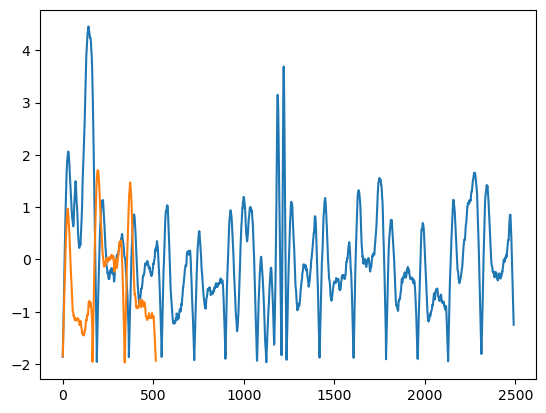

In [190]:
# plt.plot( train_GT1_filtered, label='gt')
# plt.legend()
plt.plot( train_whisker1_filtered_N[:,0])
plt.plot( test_whisker1_filtered_N[:,0])

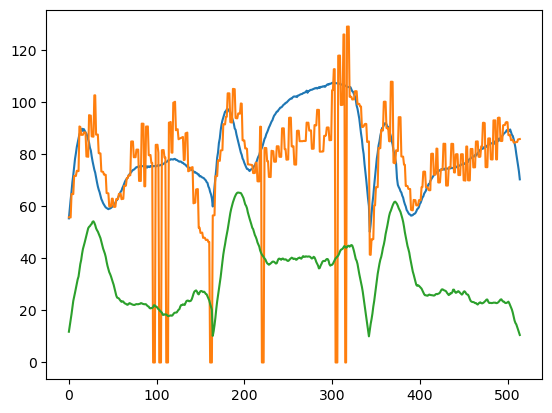

In [191]:
# plt.plot( test_whisker1_filtered)
plt.plot( test_GT1_filtered, label='gt')
plt.plot( test_laser1_filtered, label='gt')
plt.plot( test_whisker1_filtered[:,0])

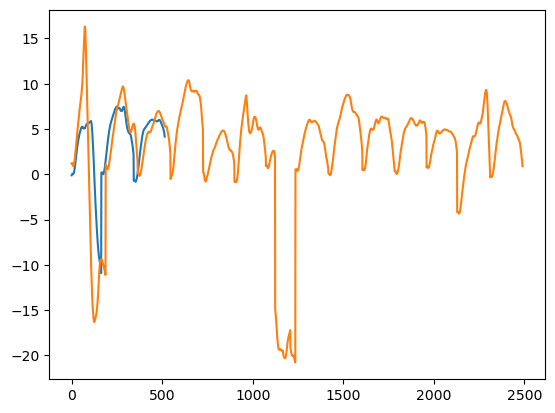

In [192]:
plt.plot(test_orientation_filtered)
plt.plot(train_orientation_filtered)

In [214]:
#whisker1 MLP Train, validation, test
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
import copy
from train import *
from model import *
from utils import *
from sklearn.model_selection import train_test_split 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#网格搜索法寻找最佳超参数组合，并在验证集上进行验证
input_size = 3 # 输入特征维度
output_size = 1 # 输出类别数
num_layers = 3  # MLP 层数
hidden_size= 32
# time_sequence_values = [40]  # 时间序列长度取值范围

best_model = None
best_loss = float('inf')
best_loss_fold = float('inf')
best_params = None
best_mean_performance = float('inf')
criterion = nn.L1Loss()

train_whisker_tensor = torch.Tensor(train_whisker1_filtered_N)
train_GT_tensor = torch.Tensor(train_GT1_filtered)
train_laser_tensor = torch.Tensor(train_laser1_filtered)
train_whisker_tensor , test_whisker_tensor, train_GT_tensor, test_GT_tensor,train_laser_tensor, test_laser_tensor = train_test_split(train_whisker_tensor, train_GT_tensor, train_laser_tensor, test_size=0.2, random_state=0)

train_dataset = TensorDataset(train_whisker_tensor, train_GT_tensor)
test_dataset = TensorDataset(test_whisker_tensor, test_GT_tensor)  

# Fixed hyperparameters
batch_size = 32
learning_rate = 0.001
regularization = 0.001
dropout = 0.1
num_epochs = 50

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
model = MLP(input_size, hidden_size, output_size, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
criterion = nn.L1Loss()

# Train the model for fixed epochs and evaluate on the test set
best_test_loss = float('inf')
best_rmse = None
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    test_loss, mse, rmse = test_model(model, test_loader, criterion)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Save the best model based on test performance
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_rmse = rmse
        best_model_state = copy.deepcopy(model.state_dict())

# Save the best model to disk
best_model_folder = 'MLP_best_model_save'
os.makedirs(best_model_folder, exist_ok=True)
best_model_file_name = f'{best_model_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_rmse_{best_rmse:.4f}_whisker1.pt'
torch.save(best_model_state, best_model_file_name)

# Evaluate the saved model and generate output images
model.load_state_dict(best_model_state)
test_image_folder = 'MLP_test_image_save_whisker1'
os.makedirs(test_image_folder, exist_ok=True)

test_image_output_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker1.png'
test_image_deviation_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker1_deviation.png'
test_image_reconstruction_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker1_reconstruction.png'

save_output_image(model, test_loader, test_laser_tensor, test_image_output_file)
save_deviation_image(model, test_loader,  test_laser_tensor, test_image_deviation_file)
# save_reconstruction_surface_1(
#     model, test_loader, test_orientation1_filtered, test_position1_filtered, 
#     test_laser1_filtered, test_image_reconstruction_file
# )

# Summary of results
print(f"Test Loss: {best_test_loss:.4f}")
print(f"RMSE: {best_rmse:.4f}")
print(f"Best model saved to {best_model_file_name}.")
print(f"Test output images saved to {test_image_folder}.")


Epoch [1/50], Train Loss: 86.6185, Test Loss: 85.2986
Epoch [2/50], Train Loss: 64.7320, Test Loss: 35.5611
Epoch [3/50], Train Loss: 26.7986, Test Loss: 22.3495
Epoch [4/50], Train Loss: 21.2768, Test Loss: 18.8724
Epoch [5/50], Train Loss: 18.5051, Test Loss: 15.2996
Epoch [6/50], Train Loss: 17.2174, Test Loss: 13.3763
Epoch [7/50], Train Loss: 15.5631, Test Loss: 12.3039
Epoch [8/50], Train Loss: 15.7705, Test Loss: 11.7777
Epoch [9/50], Train Loss: 15.2699, Test Loss: 11.5316
Epoch [10/50], Train Loss: 14.8118, Test Loss: 11.8187
Epoch [11/50], Train Loss: 14.5730, Test Loss: 11.5268
Epoch [12/50], Train Loss: 14.6625, Test Loss: 11.2384
Epoch [13/50], Train Loss: 14.8113, Test Loss: 11.3507
Epoch [14/50], Train Loss: 14.3804, Test Loss: 11.4378
Epoch [15/50], Train Loss: 14.3346, Test Loss: 10.9482
Epoch [16/50], Train Loss: 13.9741, Test Loss: 11.4759
Epoch [17/50], Train Loss: 14.2824, Test Loss: 10.7562
Epoch [18/50], Train Loss: 14.0027, Test Loss: 10.9475
Epoch [19/50], Trai

In [207]:
#whisker2 MLP Train, validation, test
import torch
import torch.nn as nn
import os
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid
import copy
from train import *
from model import *
from utils import *
from sklearn.model_selection import train_test_split 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


#网格搜索法寻找最佳超参数组合，并在验证集上进行验证
input_size = 3 # 输入特征维度
output_size = 1 # 输出类别数
num_layers = 3  # MLP 层数
hidden_size= 32
# time_sequence_values = [40]  # 时间序列长度取值范围

best_model = None
best_loss = float('inf')
best_loss_fold = float('inf')
best_params = None
best_mean_performance = float('inf')
criterion = nn.L1Loss()

train_whisker_tensor = torch.Tensor(train_whisker2_filtered_N)
train_GT_tensor = torch.Tensor(train_GT2_filtered)
train_laser_tensor = torch.Tensor(train_laser2_filtered)
train_whisker_tensor , test_whisker_tensor, train_GT_tensor, test_GT_tensor,train_laser_tensor, test_laser_tensor = train_test_split(train_whisker_tensor, train_GT_tensor, train_laser_tensor, test_size=0.2, random_state=0)

train_dataset = TensorDataset(train_whisker_tensor, train_GT_tensor)
test_dataset = TensorDataset(test_whisker_tensor, test_GT_tensor)  

# Fixed hyperparameters
batch_size = 32
learning_rate = 0.001
regularization = 0.001
dropout = 0.1
num_epochs = 50

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, optimizer, and loss function
model = MLP(input_size, hidden_size, output_size, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization)
criterion = nn.L1Loss()

# Train the model for fixed epochs and evaluate on the test set
best_test_loss = float('inf')
best_rmse = None
best_model_state = None

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    test_loss, mse, rmse = test_model(model, test_loader, criterion)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Save the best model based on test performance
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_rmse = rmse
        best_model_state = copy.deepcopy(model.state_dict())

# Save the best model to disk
best_model_folder = 'MLP_best_model_save'
os.makedirs(best_model_folder, exist_ok=True)
best_model_file_name = f'{best_model_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_rmse_{best_rmse:.4f}_whisker2.pt'
torch.save(best_model_state, best_model_file_name)

# Evaluate the saved model and generate output images
model.load_state_dict(best_model_state)
test_image_folder = 'MLP_test_image_save_whisker2'
os.makedirs(test_image_folder, exist_ok=True)

test_image_output_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker2.png'
test_image_deviation_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker2_deviation.png'
test_image_reconstruction_file = f'{test_image_folder}/mlp_bs_{batch_size}_lr_{learning_rate}_reg_{regularization}_do_{dropout}_RMSE_{best_rmse:.4f}_whisker2_reconstruction.png'

save_output_image(model, test_loader, test_laser_tensor, test_image_output_file)
save_deviation_image(model, test_loader,  test_laser_tensor, test_image_deviation_file)
# save_reconstruction_surface_1(
#     model, test_loader, test_orientation1_filtered, test_position1_filtered, 
#     test_laser1_filtered, test_image_reconstruction_file
# )

# Summary of results
print(f"Test Loss: {best_test_loss:.4f}")
print(f"RMSE: {best_rmse:.4f}")
print(f"Best model saved to {best_model_file_name}.")
print(f"Test output images saved to {test_image_folder}.")

Epoch [1/50], Train Loss: 89.5522, Test Loss: 85.7931
Epoch [2/50], Train Loss: 66.4604, Test Loss: 30.9492
Epoch [3/50], Train Loss: 27.7092, Test Loss: 21.9422
Epoch [4/50], Train Loss: 23.4387, Test Loss: 18.3821
Epoch [5/50], Train Loss: 20.3981, Test Loss: 15.3745
Epoch [6/50], Train Loss: 17.3374, Test Loss: 12.8594
Epoch [7/50], Train Loss: 14.9292, Test Loss: 11.0213
Epoch [8/50], Train Loss: 14.6336, Test Loss: 11.3290
Epoch [9/50], Train Loss: 13.8741, Test Loss: 9.2837
Epoch [10/50], Train Loss: 13.5885, Test Loss: 9.7585
Epoch [11/50], Train Loss: 13.7817, Test Loss: 8.7359
Epoch [12/50], Train Loss: 13.5321, Test Loss: 9.1324
Epoch [13/50], Train Loss: 13.0638, Test Loss: 8.5001
Epoch [14/50], Train Loss: 12.8860, Test Loss: 9.9957
Epoch [15/50], Train Loss: 12.6966, Test Loss: 8.5497
Epoch [16/50], Train Loss: 12.6668, Test Loss: 8.7368
Epoch [17/50], Train Loss: 12.8587, Test Loss: 8.8257
Epoch [18/50], Train Loss: 12.4915, Test Loss: 8.4691
Epoch [19/50], Train Loss: 12

RMSE                = 223.23399824254653
MAE             = 12.517199095557718


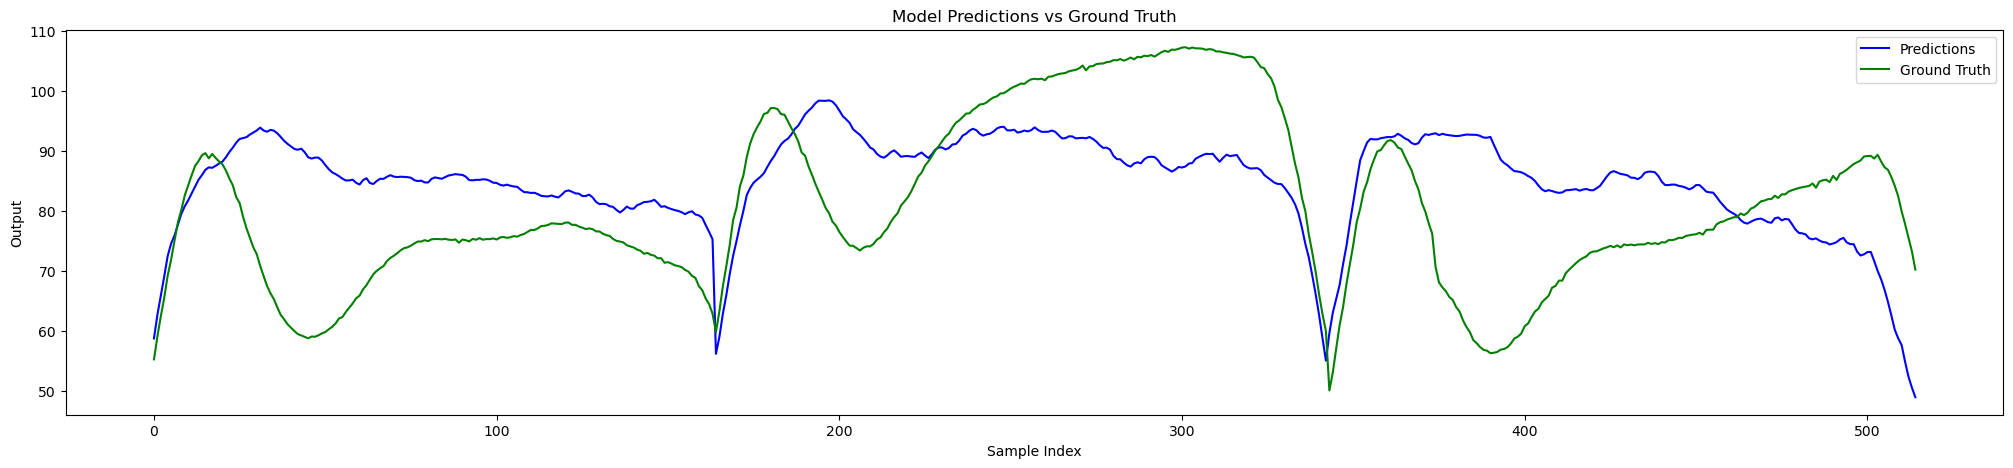

In [215]:
#whisker1 uncertainty aware mlp
from utils import evaluate
from model import *
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size=3, hidden_size=32, output_size=1, dropout_prob=0).to(device)
best_model_path='MLP_best_model_save//mlp_bs_32_lr_0.001_reg_0.001_do_0.1_rmse_12.8143_whisker1.pt'
model.load_state_dict(torch.load(best_model_path))
test_whisker_tensor = torch.Tensor(test_whisker1_filtered_N)
test_GT_tensor = torch.Tensor(test_GT1_filtered)
test_dataset = TensorDataset(test_whisker_tensor, test_GT_tensor)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_image_folder = 'MLP_test_image_save_whisker1'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file = f'{test_image_folder}/whisker1.png'
RMSE, MAE, test_pre1 = evaluate(
        model,
        test_dataset,
        test_image_output_file)


print('RMSE                = {}'.format(RMSE))
print('MAE             = {}'.format(MAE))


RMSE                = 163.09253557990579
MAE             = 10.11353063583374


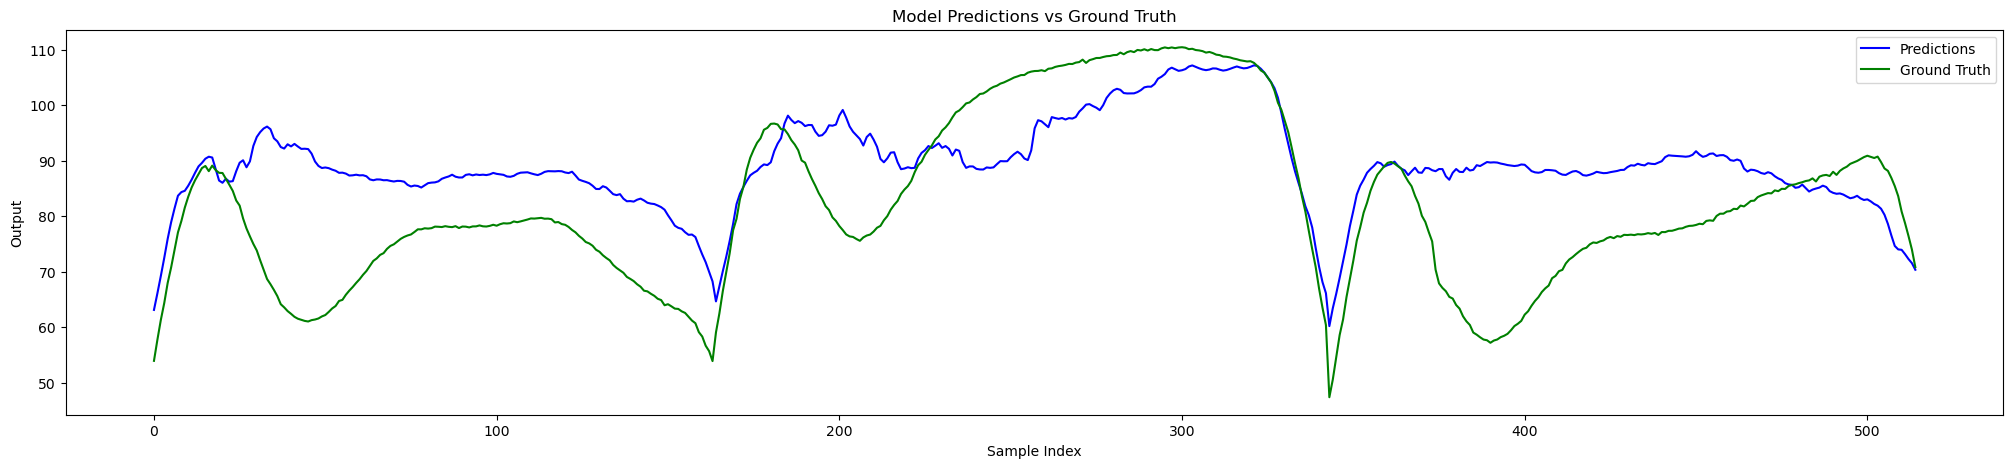

In [218]:
#whisker2 aware mlp
from utils import evaluate
from model import *
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_size=3, hidden_size=32, output_size=1, dropout_prob=0.1).to(device)
best_model_path='MLP_best_model_save/mlp_bs_32_lr_0.001_reg_0.001_do_0.1_rmse_9.8377_whisker2.pt'
model.load_state_dict(torch.load(best_model_path))
test_whisker_tensor = torch.Tensor(test_whisker2_filtered_N)
test_GT_tensor = torch.Tensor(test_GT2_filtered)
test_dataset = TensorDataset(test_whisker_tensor, test_GT_tensor)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_image_folder = 'MLP_test_image_save_whisker2'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file = f'{test_image_folder}/whisker2.png'
RMSE, MAE, test_pre2 = evaluate(
        model,
        test_dataset,
        test_image_output_file)


print('RMSE                = {}'.format(RMSE))
print('MAE             = {}'.format(MAE))

[array([58.789318], dtype=float32), array([62.70325512]), array([66.08638606]), array([69.10822088]), array([72.15454291]), array([74.97200915]), array([72.38546942]), array([70.84163783]), array([75.79851058]), array([78.54069352]), array([81.4895644]), array([83.66977224]), array([85.11903092]), array([87.74397959]), array([88.1964907]), array([88.64384941]), array([89.08128502]), array([89.62345454]), array([89.20362813]), array([88.65216695]), array([86.95882914]), array([86.5138579]), array([85.60425757]), array([84.94948708]), array([82.61614306]), array([81.02936949]), array([81.19145098]), array([80.26236876]), array([79.64480662]), array([79.08430977]), array([77.08992359]), array([76.83929894]), array([75.74222535]), array([74.41529524]), array([73.68802947]), array([73.60240928]), array([72.92344469]), array([72.14977815]), array([72.34280552]), array([72.58225483]), array([70.82808509]), array([71.42050555]), array([71.77492495]), array([71.58441362]), array([71.23506767]),

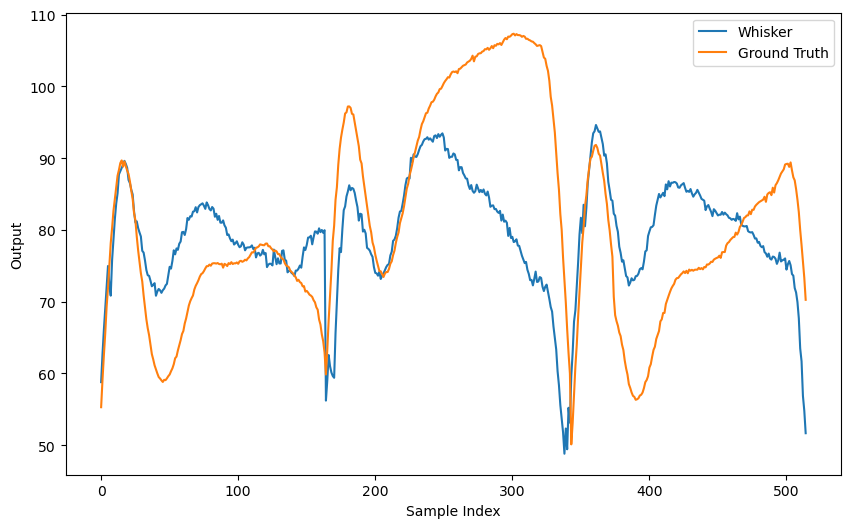

In [217]:
#KF Flat2 whisker1
import numpy as np
import os
import matplotlib.pyplot as plt
from KF import KalmanFilterFLAT2
from sklearn.metrics import mean_squared_error, mean_absolute_error

def apply_kalman_filterFLAT2(initial_state, initial_position, initial_yaw, test_pre, positions, yaws):
    kf = KalmanFilterFLAT2(initial_state, initial_position, initial_yaw, initial_covariance, process_noise, measurement_noise)
    estimates = [np.array([initial_state])]
    for z, position, yaw in zip(test_pre[1:], positions[1:], yaws[1:]):
        kf.predict(position, yaw)
        kf.update(np.array([240 - z]))
        estimates.append(kf.get_current_estimate())
    return estimates

# 数据分段
test_GT1_filtered_1 = test_GT1_filtered[0:164]
test_GT1_filtered_2 = test_GT1_filtered[164:343]
test_GT1_filtered_3 = test_GT1_filtered[343:515]
test_pre1_1 = test_pre1[0:164]
test_pre1_2 = test_pre1[164:343]
test_pre1_3 = test_pre1[343:515]
test_position1_1 = test_position_filtered[0:164]
test_position1_2 = test_position_filtered[164:343]
test_position1_3 = test_position_filtered[343:515]
test_yaw1_1 = test_orientation_filtered[0:164]
test_yaw1_2 = test_orientation_filtered[164:343]
test_yaw1_3 = test_orientation_filtered[343:515]
# 初始状态和噪声配置
initial_states = [test_pre1_1[0], test_pre1_2[0], test_pre1_3[0]]
initial_positions = [test_position1_1[0], test_position1_2[0], test_position1_3[0]]
initial_yaws = [test_yaw1_1[0], test_yaw1_2[0], test_yaw1_3[0]]
initial_covariance = np.array([[50]])
process_noise = np.array([[0.001]])
measurement_noise = np.array([[1]])

# 应用卡尔曼滤波
test_kal1_1 = apply_kalman_filterFLAT2(initial_states[0], initial_positions[0], initial_yaws[0], test_pre1_1, test_position1_1, test_yaw1_1)
test_kal1_2 = apply_kalman_filterFLAT2(initial_states[1], initial_positions[1], initial_yaws[1],test_pre1_2, test_position1_2, test_yaw1_2)
test_kal1_3 = apply_kalman_filterFLAT2(initial_states[2], initial_positions[2], initial_yaws[2],test_pre1_3, test_position1_3, test_yaw1_3)

# 合并结果
test_kal1 = test_kal1_1 + test_kal1_2 + test_kal1_3
print(test_kal1)
# 计算损失
MSE_loss = mean_squared_error(test_kal1, test_GT1_filtered)
MAE_loss = mean_absolute_error(test_kal1, test_GT1_filtered)

print(f'MSE = {MSE_loss}')
print(f'MAE = {MAE_loss}')

# 保存图像
test_image_folder = 'FLAT_MLP_KF_test_image_save_whisker1'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file = f'{test_image_folder}/whisker1_kf_certainnoise_50_0.1_1.png'

plt.figure(figsize=(10, 6))
plt.plot(test_kal1, label='Whisker')
plt.plot(test_GT1_filtered, label='Ground Truth')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.savefig(test_image_output_file)

[array([63.09022], dtype=float32), array([66.08515672]), array([69.44031331]), array([72.46053948]), array([75.54086388]), array([78.58720997]), array([76.30490841]), array([75.03397566]), array([80.05667601]), array([82.75178438]), array([85.67170149]), array([87.83762238]), array([89.29136974]), array([91.90703347]), array([92.40008128]), array([92.89848572]), array([93.35062186]), array([93.97894994]), array([93.50814524]), array([92.78107372]), array([90.8121869]), array([90.22578092]), array([89.05077295]), array([88.19356131]), array([85.69370853]), array([83.9913358]), array([84.05979836]), array([82.89608442]), array([82.18372373]), array([81.55334995]), array([79.60756691]), array([79.24699546]), array([78.17446579]), array([76.95634393]), array([76.20184096]), array([76.01097213]), array([75.28388623]), array([74.39245745]), array([74.46043394]), array([74.66048943]), array([72.82525422]), array([73.44104433]), array([73.7705618]), array([73.51785529]), array([73.07754891]), 

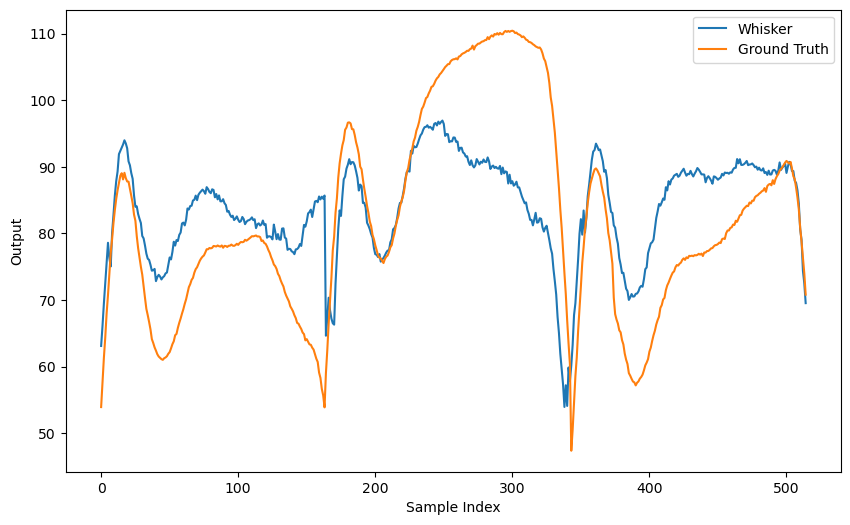

In [ ]:
#KF Flat2 whisker2
import numpy as np
import os
import matplotlib.pyplot as plt
from KF import KalmanFilterFLAT2
from sklearn.metrics import mean_squared_error, mean_absolute_error

def apply_kalman_filterFLAT2(initial_state, initial_position, initial_yaw, test_pre, positions, yaws):
    kf = KalmanFilterFLAT2(initial_state, initial_position, initial_yaw, initial_covariance, process_noise, measurement_noise)
    estimates = [np.array([initial_state])]
    for z, position, yaw in zip(test_pre[1:], positions[1:], yaws[1:]):
        kf.predict(position, yaw)
        kf.update(np.array([240 - z]))
        estimates.append(kf.get_current_estimate())
    return estimates

# 数据分段
test_GT2_filtered_1 = test_GT2_filtered[0:164]
test_GT2_filtered_2 = test_GT2_filtered[164:343]
test_GT2_filtered_3 = test_GT2_filtered[343:515]
test_pre2_1 = test_pre2[0:164]
test_pre2_2 = test_pre2[164:343]
test_pre2_3 = test_pre2[343:515]
test_position2_1 = test_position_filtered[0:164]
test_position2_2 = test_position_filtered[164:343]
test_position2_3 = test_position_filtered[343:515]
test_yaw2_1 = test_orientation_filtered[0:164] - 2.6
test_yaw2_2 = test_orientation_filtered[164:343] - 2.6
test_yaw2_3 = test_orientation_filtered[343:515] - 2.6
# 初始状态和噪声配置
initial_states = [test_pre2_1[0], test_pre2_2[0], test_pre2_3[0]]
initial_positions = [test_position2_1[0], test_position2_2[0], test_position2_3[0]]
initial_yaws = [test_yaw2_1[0], test_yaw2_2[0], test_yaw2_3[0]]
initial_covariance = np.array([[50]])
process_noise = np.array([[0.001]])
measurement_noise = np.array([[1]])

# 应用卡尔曼滤波
test_kal2_1 = apply_kalman_filterFLAT2(initial_states[0], initial_positions[0], initial_yaws[0], test_pre2_1, test_position2_1, test_yaw2_1)
test_kal2_2 = apply_kalman_filterFLAT2(initial_states[1], initial_positions[1], initial_yaws[1],test_pre2_2, test_position2_2, test_yaw2_2)
test_kal2_3 = apply_kalman_filterFLAT2(initial_states[2], initial_positions[2], initial_yaws[2],test_pre2_3, test_position2_3, test_yaw2_3)

# 合并结果
test_kal2 = test_kal2_1 + test_kal2_2 + test_kal2_3
print(test_kal2)
# 计算损失
MSE_loss = mean_squared_error(test_kal2, test_GT2_filtered)
MAE_loss = mean_absolute_error(test_kal2, test_GT2_filtered)

print(f'MSE = {MSE_loss}')
print(f'MAE = {MAE_loss}')

# 保存图像
test_image_folder = 'FLAT_MLP_KF_test_image_save_whisker2'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file = f'{test_image_folder}/whisker2_kf_certainnoise_50_0.1_1.png'

plt.figure(figsize=(10, 6))
plt.plot(test_kal2, label='Whisker')
plt.plot(test_GT2_filtered, label='Ground Truth')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.savefig(test_image_output_file)

wall_rad = -0.13327406155141963
wall_rad = [-0.11425733]
wall_rad = [-0.11245822]
wall_rad = [-0.11157922]
wall_rad = [-0.11150719]
wall_rad = [-0.1151764]
wall_rad = [-0.12167664]
wall_rad = [-0.1277572]
wall_rad = [-0.12907364]
wall_rad = [-0.12772496]
wall_rad = [-0.12618883]
wall_rad = [-0.12458092]
wall_rad = [-0.1231211]
wall_rad = [-0.12156595]
wall_rad = [-0.11921154]
wall_rad = [-0.11665011]
wall_rad = [-0.11379139]
wall_rad = [-0.11063818]
wall_rad = [-0.10499516]
wall_rad = [-0.09675499]
wall_rad = [-0.08805973]
wall_rad = [-0.07972599]
wall_rad = [-0.07059859]
wall_rad = [-0.06147395]
wall_rad = [-0.05356168]
wall_rad = [-0.04707607]
wall_rad = [-0.04090727]
wall_rad = [-0.03412356]
wall_rad = [-0.02781579]
wall_rad = [-0.02377339]
wall_rad = [-0.02052003]
wall_rad = [-0.01791256]
wall_rad = [-0.01605029]
wall_rad = [-0.01444639]
wall_rad = [-0.01254117]
wall_rad = [-0.00989211]
wall_rad = [-0.00730895]
wall_rad = [-0.00458986]
wall_rad = [-0.00221024]
wall_rad = [-0.000565

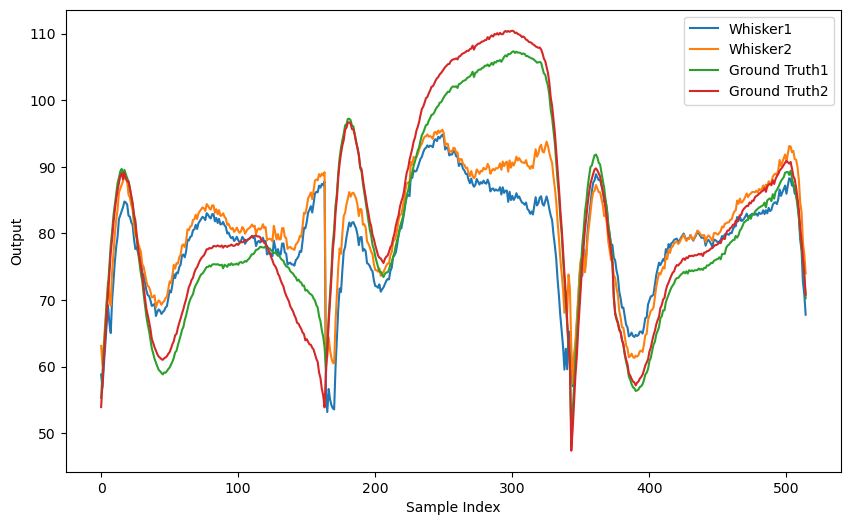

In [225]:
#KF Flat3_seperate whisker1 and whisker2
import numpy as np
import os
import matplotlib.pyplot as plt
from KF import KalmanFilterFLAT3_seperate
from sklearn.metrics import mean_squared_error, mean_absolute_error

def apply_kalman_filterFLAT3(initial_state1, initial_state2, initial_position, initial_yaw, test_pre1, test_pre2, positions, yaws, fading_factor):
    kf = KalmanFilterFLAT3_seperate(initial_state1, initial_state2, initial_position, initial_yaw, initial_covariance, process_noise, measurement_noise, fading_factor)
    estimates1 = [np.array([initial_state1])]
    estimates2 = [np.array([initial_state2])]
    estimates = [np.array([0])]
    for z1, z2, position, yaw in zip(test_pre1[1:], test_pre2[1:], positions[1:], yaws[1:]):
        kf.predict(position, yaw)
        kf.update(np.array([240 - z1]), np.array([240 - z2]))
        estimate1, estimate2 = kf.get_current_estimate()
        estimates1.append(estimate1)
        estimates2.append(estimate2)
    return estimates1, estimates2

fading_factor = 1


# 数据分段 whisker1
test_GT1_filtered_1 = test_GT1_filtered[0:164]
test_GT1_filtered_2 = test_GT1_filtered[164:343]
test_GT1_filtered_3 = test_GT1_filtered[343:515]
test_pre1_1 = test_pre1[0:164]
test_pre1_2 = test_pre1[164:343]
test_pre1_3 = test_pre1[343:515]

# 数据分段 whisker2
test_GT2_filtered_1 = test_GT2_filtered[0:164]
test_GT2_filtered_2 = test_GT2_filtered[164:343]
test_GT2_filtered_3 = test_GT2_filtered[343:515]
test_pre2_1 = test_pre2[0:164]
test_pre2_2 = test_pre2[164:343]
test_pre2_3 = test_pre2[343:515]

# 数据分段 both
test_position_1 = test_position_filtered[0:164]
test_position_2 = test_position_filtered[164:343]
test_position_3 = test_position_filtered[343:515]
test_yaw_1 = test_orientation_filtered[0:164] - 2.6
test_yaw_2 = test_orientation_filtered[164:343] - 2.6
test_yaw_3 = test_orientation_filtered[343:515] - 2.6

# 初始状态和噪声配置
initial_states1 = [test_pre1_1[0], test_pre1_2[0], test_pre1_3[0]]
initial_states2 = [test_pre2_1[0], test_pre2_2[0], test_pre2_3[0]]
initial_positions = [test_position_1[0], test_position_2[0], test_position_3[0]]
initial_yaws = [test_yaw_1[0], test_yaw_2[0], test_yaw_3[0]]
initial_covariance = np.array([[50]])
process_noise = np.array([[0.0001]])
measurement_noise = np.array([[1]])

# 应用卡尔曼滤波
test_kal1_1, test_kal2_1= apply_kalman_filterFLAT3(initial_states1[0], initial_states2[0], initial_positions[0], initial_yaws[0], test_pre1_1, test_pre2_1, test_position_1, test_yaw_1, fading_factor)
test_kal1_2, test_kal2_2= apply_kalman_filterFLAT3(initial_states1[1], initial_states2[0], initial_positions[1], initial_yaws[1], test_pre1_2, test_pre2_2, test_position_2, test_yaw_2, fading_factor)
test_kal1_3, test_kal2_3= apply_kalman_filterFLAT3(initial_states1[2], initial_states2[0], initial_positions[2], initial_yaws[2], test_pre1_3, test_pre2_3, test_position_3, test_yaw_3, fading_factor)

# 合并结果
test_kal1 = test_kal1_1 + test_kal1_2 + test_kal1_3
test_kal2 = test_kal2_1 + test_kal2_2 + test_kal2_3
print(test_kal1)
print(test_kal2)
# 计算损失
MSE_loss_1 = mean_squared_error(test_kal1, test_GT1_filtered)
MAE_loss_1 = mean_absolute_error(test_kal1, test_GT1_filtered)
MSE_loss_2 = mean_squared_error(test_kal2, test_GT2_filtered)
MAE_loss_2 = mean_absolute_error(test_kal2, test_GT2_filtered)

print(f'whisker1 MSE = {MSE_loss_1}')
print(f'whisker1 MAE = {MAE_loss_1}')
print(f'whisker2 MSE = {MSE_loss_2}')
print(f'whisker2 MAE = {MAE_loss_2}')

# 保存图像
test_image_folder = 'FLAT3_MLP_KF_test_image_save_whisker1+2'
os.makedirs(test_image_folder, exist_ok=True)
test_image_output_file_1 = f'{test_image_folder}/p_0.05_noise_1e-2_modelvarianceweight_1_whisker1_kf_certainnoise_50_0.1_1_1.png'

plt.figure(figsize=(10, 6))
# plt.plot(test_kal, label='Whisker')
plt.plot(test_kal1, label='Whisker1')
plt.plot(test_kal2, label='Whisker2')
plt.plot(test_GT1_filtered, label='Ground Truth1')
plt.plot(test_GT2_filtered, label='Ground Truth2')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Output')
plt.savefig(test_image_output_file)


In [10]:
save_deviation_image(model, test_loader,  test_laser_tensor, test_image_deviation_file)
save_reconstruction_surface_1(
    model, test_loader, test_orientation1_filtered, test_position1_filtered, 
    test_laser1_filtered, test_image_reconstruction_file
)

ValueError: operands could not be broadcast together with shapes (495,) (711,) 

In [6]:
print(calculate_distance_to_line(0.639973759651184,-1.95227956771851, np.rad2deg(-0.146386876101629)- 0.064))

0.12443213819136777


In [7]:
x1, y1 =  -2.240269,0.749876

x2, y2 =  -0.986052, 0.811162



# Calculate the angle with respect to the X-axis

delta_x = x2 - x1

delta_y = y2 - y1



# Angle in radians

angle_radians = math.atan2(delta_y, delta_x)



# Convert to degrees

angle_degrees = math.degrees(angle_radians)
print(angle_degrees)

2.797473172728386


In [8]:
calculate_distance_to_line

<function __main__.calculate_distance_to_line(xp, yp, yaw, x1=0.749876, y1=-2.240269, x2=0.811162, y2=-0.986052)>